# 3DGS Render in Python Code
> see repo: https://github.com/SY-007-Research/3dgs_render_python
> 

In [1]:
import sys
sys.path.append('/home/ccj/code/my_github_projs/learn-3dv-up2date/third_parties/3dgs_render_python')

import math
import numpy as np
from tqdm import tqdm
from loguru import logger
from math import sqrt, ceil
import sys

from render_python import computeColorFromSH
from render_python import computeCov2D, computeCov3D
from render_python import transformPoint4x4, in_frustum
from render_python import getWorld2View2, getProjectionMatrix, ndc2Pix, in_frustum

In [2]:
class Rasterizer:
    def __init__(self) -> None:
        pass

    def forward(
        self,
        P,  # int, num of guassians
        D,  # int, degree of spherical harmonics
        M,  # int, num of sh base function
        background,  # color of background, default black
        width,  # int, width of output image
        height,  # int, height of output image
        means3D,  # ()center position of 3d gaussian
        shs,  # spherical harmonics coefficient
        colors_precomp,
        opacities,  # opacities
        scales,  # scale of 3d gaussians
        scale_modifier,  # default 1
        rotations,  # rotation of 3d gaussians
        cov3d_precomp,
        viewmatrix,  # matrix for view transformation
        projmatrix,  # *(4, 4), matrix for transformation, aka mvp
        cam_pos,  # position of camera
        tan_fovx,  # float, tan value of fovx
        tan_fovy,  # float, tan value of fovy
        prefiltered,
    ) -> None:

        focal_y = height / (2 * tan_fovy)  # focal of y axis
        focal_x = width / (2 * tan_fovx)

        # run preprocessing per-Gaussians
        # transformation, bounding, conversion of SHs to RGB
        logger.info("Starting preprocess per 3d gaussian...")
        preprocessed = self.preprocess(
            P,
            D,
            M,
            means3D,
            scales,
            scale_modifier,
            rotations,
            opacities,
            shs,
            viewmatrix,
            projmatrix,
            cam_pos,
            width,
            height,
            focal_x,
            focal_y,
            tan_fovx,
            tan_fovy,
        )

        # produce [depth] key and corresponding guassian indices
        # sort indices by depth
        depths = preprocessed["depths"]
        point_list = np.argsort(depths)

        # render
        logger.info("Starting render...")
        out_color = self.render(
            point_list,
            width,
            height,
            preprocessed["points_xy_image"],
            preprocessed["rgbs"],
            preprocessed["conic_opacity"],
            background,
        )
        return out_color

    def preprocess(
        self,
        P,
        D,
        M,
        orig_points,
        scales,
        scale_modifier,
        rotations,
        opacities,
        shs,
        viewmatrix,
        projmatrix,
        cam_pos,
        W,
        H,
        focal_x,
        focal_y,
        tan_fovx,
        tan_fovy,
    ):

        rgbs = []  # rgb colors of gaussians
        cov3Ds = []  # covariance of 3d gaussians
        depths = []  # depth of 3d gaussians after view&proj transformation
        radii = []  # radius of 2d gaussians
        conic_opacity = []  # covariance inverse of 2d gaussian and opacity
        points_xy_image = []  # mean of 2d guassians
        for idx in range(P):
            # make sure point in frustum
            p_orig = orig_points[idx]
            p_view = in_frustum(p_orig, viewmatrix)
            if p_view is None:
                continue
            depths.append(p_view[2])

            # transform point, from world to ndc
            # Notice, projmatrix already processed as mvp matrix
            p_hom = transformPoint4x4(p_orig, projmatrix)
            p_w = 1 / (p_hom[3] + 0.0000001)
            p_proj = [p_hom[0] * p_w, p_hom[1] * p_w, p_hom[2] * p_w]

            # compute 3d covarance by scaling and rotation parameters
            scale = scales[idx]
            rotation = rotations[idx]
            cov3D = computeCov3D(scale, scale_modifier, rotation)
            cov3Ds.append(cov3D)

            # compute 2D screen-space covariance matrix
            # based on splatting, -> JW Sigma W^T J^T
            cov = computeCov2D(
                p_orig, focal_x, focal_y, tan_fovx, tan_fovy, cov3D, viewmatrix
            )

            # invert covarance(EWA splatting)
            det = cov[0] * cov[2] - cov[1] * cov[1]
            if det == 0:
                depths.pop()
                cov3Ds.pop()
                continue
            det_inv = 1 / det
            conic = [cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv]
            conic_opacity.append([conic[0], conic[1], conic[2], opacities[idx]])

            # compute radius, by finding eigenvalues of 2d covariance
            # transfrom point from NDC to Pixel
            mid = 0.5 * (cov[0] + cov[1])
            lambda1 = mid + sqrt(max(0.1, mid * mid - det))
            lambda2 = mid - sqrt(max(0.1, mid * mid - det))
            my_radius = ceil(3 * sqrt(max(lambda1, lambda2)))
            point_image = [ndc2Pix(p_proj[0], W), ndc2Pix(p_proj[1], H)]

            radii.append(my_radius)
            points_xy_image.append(point_image)

            # convert spherical harmonics coefficients to RGB color
            sh = shs[idx]
            result = computeColorFromSH(D, p_orig, cam_pos, sh)
            rgbs.append(result)

        return dict(
            rgbs=rgbs,
            cov3Ds=cov3Ds,
            depths=depths,
            radii=radii,
            conic_opacity=conic_opacity,
            points_xy_image=points_xy_image,
        )

    def render(
        self, point_list, W, H, points_xy_image, features, conic_opacity, bg_color
    ):

        out_color = np.zeros((H, W, 3))
        pbar = tqdm(range(H * W))

        # loop pixel
        for i in range(H):
            for j in range(W):
                pbar.update(1)
                pixf = [i, j]
                C = [0, 0, 0]

                # loop gaussian
                for idx in point_list:

                    # init helper variables, transmirrance
                    T = 1

                    # Resample using conic matrix
                    # (cf. "Surface Splatting" by Zwicker et al., 2001)
                    xy = points_xy_image[idx]  # center of 2d gaussian
                    d = [
                        xy[0] - pixf[0],
                        xy[1] - pixf[1],
                    ]  # distance from center of pixel
                    con_o = conic_opacity[idx]
                    power = (
                        -0.5 * (con_o[0] * d[0] * d[0] + con_o[2] * d[1] * d[1])
                        - con_o[1] * d[0] * d[1]
                    )
                    if power > 0:
                        continue

                    # Eq. (2) from 3D Gaussian splatting paper.
                    # Compute color
                    alpha = min(0.99, con_o[3] * np.exp(power))
                    if alpha < 1 / 255:
                        continue
                    test_T = T * (1 - alpha)
                    if test_T < 0.0001:
                        break

                    # Eq. (3) from 3D Gaussian splatting paper.
                    color = features[idx]
                    for ch in range(3):
                        C[ch] += color[ch] * alpha * T

                    T = test_T

                # get final color
                for ch in range(3):
                    out_color[j, i, ch] = C[ch] + T * bg_color[ch]

        return out_color

Let us run it.

2025-03-21 08:13:20.741 | INFO     | __main__:forward:34 - Starting preprocess per 3d gaussian...
2025-03-21 08:13:20.742 | INFO     | __main__:forward:62 - Starting render...


pts =  [[ 2  0 -2]
 [ 0  2 -2]
 [-2  0 -2]]


  0%|                                                                                                                             | 0/490000 [00:00<?, ?it/s]/tmp/ipykernel_3113684/1112850701.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out_color[j, i, ch] = C[ch] + T * bg_color[ch]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490000/490000 [00:10<00:00, 44792.58it/s]


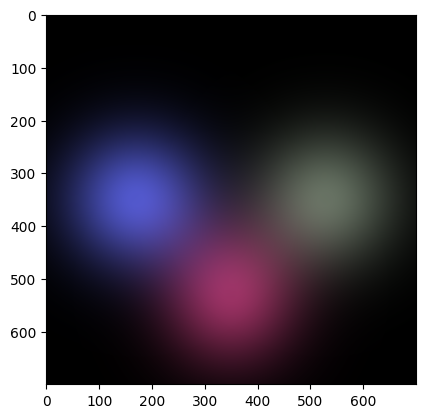

In [5]:
# set guassian
if 1:
    pts = np.array([[2, 0, -2], [0, 2, -2], [-2, 0, -2]])
    n = len(pts)
    print ("pts = ", pts)
    shs = np.random.random((n, 16, 3))
    opacities = np.ones((n, 1))
    scales = np.ones((n, 3))
    rotations = np.array([np.eye(3)] * n)

    # set camera
    cam_pos = np.array([0, 0, 5])
    R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])
    proj_param = {"znear": 0.01, "zfar": 100, "fovX": 45, "fovY": 45}
    viewmatrix = getWorld2View2(R=R, t=cam_pos)
    projmatrix = getProjectionMatrix(**proj_param)
    projmatrix = np.dot(projmatrix, viewmatrix)
    tanfovx = math.tan(proj_param["fovX"] * 0.5)
    tanfovy = math.tan(proj_param["fovY"] * 0.5)

    # render
    rasterizer = Rasterizer()
    out_color = rasterizer.forward(
        P=len(pts),
        D=3,
        M=16,
        background=np.array([0, 0, 0]),
        width=700,
        height=700,
        means3D=pts,
        shs=shs,
        colors_precomp=None,
        opacities=opacities,
        scales=scales,
        scale_modifier=1,
        rotations=rotations,
        cov3d_precomp=None,
        viewmatrix=viewmatrix,
        projmatrix=projmatrix,
        cam_pos=cam_pos,
        tan_fovx=tanfovx,
        tan_fovy=tanfovy,
        prefiltered=None,
    )

    import matplotlib.pyplot as plt

    plt.imshow(out_color)
    plt.show()
